# Politics

We show how to use scikit-network to analyse the way deputies vote and their proximity to the majority. We here consider the French National Assembly (XVth legislature, from 2017 to 2020). The considered graph is the bipartite graph between deputies and bills.

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np

In [59]:
from sknetwork.data import load_netset
from sknetwork.clustering import Louvain
from sknetwork.regression import Diffusion
from sknetwork.ranking import top_k, PageRank
from sknetwork.embedding import Spectral
from sknetwork.visualization import svg_graph, svg_dendrogram

## Data

The dataset is part of the [NetSet](https://netset.telecom-paris.fr/pages/national_assembly.html) collection. 

In [4]:
graph = load_netset('national_assembly')

Parsing files...
Done.


In [116]:
biadjacency = graph.biadjacency
position = graph.position
names = graph.names_row
bills = graph.names_col
labels = graph.labels
label_colors = graph.label_colors
names_labels = graph.names_labels

In [38]:
n_deputy, n_bill = biadjacency.shape

In [39]:
print(names_labels)

['Non inscrit' 'Les Républicains'
 'Les Constructifs : républicains, UDI, indépendants'
 'Libertés et Territoires' 'UDI et Indépendants'
 'UDI, Agir et Indépendants' 'Mouvement Démocrate et apparentés'
 'La République en Marche' 'Socialistes et apparentés' 'Nouvelle Gauche'
 'Gauche démocrate et républicaine' 'La France insoumise']


In [40]:
# parameters for visualization
node_size = 4
width = 480
height = 300

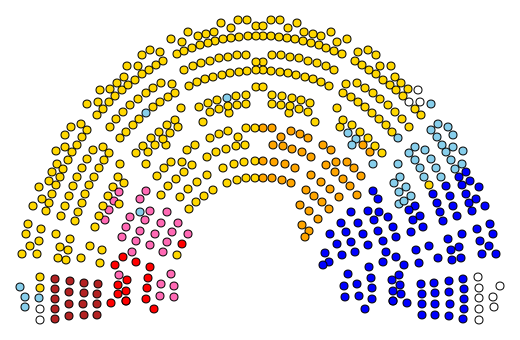

In [41]:
image = svg_graph(position=position, labels=labels, node_size=node_size, width=width, height=height, 
                  label_colors=label_colors)
SVG(image)

In [42]:
labels_majority = [6,7]

In [43]:
print(names_labels[labels_majority])

['Mouvement Démocrate et apparentés' 'La République en Marche']


In [68]:
# majority
majority = np.isin(labels, labels_majority)
np.sum(majority)

356

In [69]:
# opposition
opposition = ~np.isin(labels, labels_majority)
np.sum(opposition)

221

## Votes

In [51]:
biadjacency_for = biadjacency > 0
biadjacency_against = (-biadjacency > 0)

In [52]:
biadjacency_for

<577x2807 sparse matrix of type '<class 'numpy.bool_'>'
	with 119901 stored elements in Compressed Sparse Row format>

In [53]:
bills_for = biadjacency_for.T.dot(np.ones(n_deputy))
bills_against = biadjacency_against.T.dot(np.ones(n_deputy))
bills_total = bills_for + bills_against

In [54]:
print('Average participation = ', np.round(np.sum(bills_total) / n_bill / n_deputy, 2))

Average participation =  0.17


## Clustering

In [60]:
louvain = Louvain()

In [61]:
labels_pred = louvain.fit_transform(biadjacency_for)

In [62]:
np.unique(labels_pred, return_counts=True)

(array([0, 1, 2]), array([213, 363,   1]))

In [73]:
labels_pred_majority, counts_majority = np.unique(labels_pred[majority], return_counts=True)

In [74]:
label_pred_majority = labels_pred_majority[np.argmax(counts_majority)]

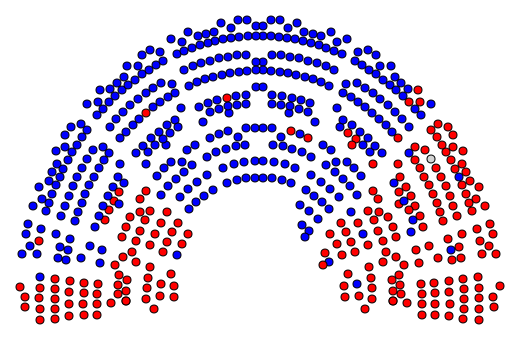

In [67]:
image = svg_graph(position=position, labels=labels_pred, node_size=node_size, width=width, height=height, label_colors=['red','blue', 'lightgrey'])
SVG(image)

In [63]:
neutral = np.argwhere(labels_pred==2).ravel()

In [65]:
print(names[neutral])

['Laure de La Raudière']


In [78]:
# dissident
print(names[majority * (labels_pred!=label_pred_majority)])

['Frédérique Dumas' 'Maud Petit' 'Sonia Krimi' 'Richard Ramos'
 'Sébastien Nadot']


## Diffusion

In [148]:
diffusion = Diffusion(n_iter=4)

In [149]:
values = diffusion.fit_transform(biadjacency_for, seeds_row=majority)

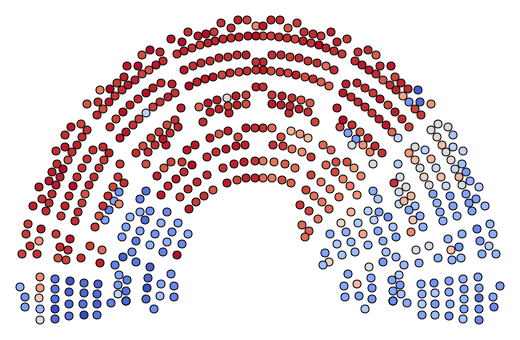

In [151]:
image = svg_graph(position=position, scores=values, node_size=node_size, 
                  width=width, height=height)
SVG(image)

In [140]:
# top-10 deputies for majority
index = np.argwhere(majority).ravel()
top = index[top_k(values[index], 10)]
print(names[top])

['Émilie Chalas' 'Didier Paris' 'Richard Ferrand'
 'Élise Fajgeles|||Benjamin Griveaux' 'Guillaume Vuilletet'
 'Yaël Braun-Pivet' 'Marie Guévenoux' 'Jean Terlier' 'Sacha Houlié'
 'Thomas Rudigoz']


In [141]:
# bottom-10 deputies for majority
bottom = index[top_k(-values[index], 10)]
print(names[bottom])

['Frédérique Dumas' 'Maud Petit' 'Richard Ramos' 'Agnès Thill'
 'Brahim Hammouche' 'Sébastien Nadot' 'Jimmy Pahun' 'Josy Poueyto'
 'Sonia Krimi' 'Max Mathiasin']


In [142]:
# top-10 deputies for opposition
index = np.argwhere(opposition).ravel()
top = index[top_k(-values[index], 10)]
print(names[top])

['Ugo Bernalicis' 'Adrien Quatennens' 'Alain Bruneel' 'Clémentine Autain'
 'Nicolas Dupont-Aignan' 'Alexis Corbière' 'Jean-Luc Mélenchon'
 'Sébastien Jumel' 'Jean-Hugues Ratenon' 'Pierre Dharréville']


In [143]:
# bottom-10 deputies for opposition
bottom = index[top_k(values[index], 10)]
print(names[bottom])

['Jean-Luc Warsmann' 'Olivier Dassault' 'Napole Polutele|||Sylvain Brial'
 'Stéphane Demilly' 'Michèle Tabarot' 'Bernard Deflesselles'
 'Franck Riester|||Patricia Lemoine' 'Thierry Robert|||Jean-Luc Poudroux'
 'Laure de La Raudière' 'Philippe Gomès']


## Bills

In [152]:
# labels are on deputies so you need an odd number of iterations
diffusion = Diffusion(n_iter=5)

In [153]:
diffusion.fit(biadjacency_for, seeds_row=majority)

Diffusion(n_iter=5, damping_factor=1.0)

In [154]:
values_bill = diffusion.values_col_

In [158]:
# top-5 bills for majority
for i in top_k(values_bill, 5):
    print(bills[i] + '\n')

l'article 27 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement de suppression n° 72 du Gouvernement à l'article 9 de la proposition de loi d'orientation et de programmation relative à la sécurité intérieure (première lecture).

l'amendement de suppression n° 71 du Gouvernement à l'article 3 de la proposition de loi d'orientation et de programmation relative à la sécurité intérieure (première lecture).

l'amendement n° 2362  de Mme Marsaud après l'article 60 du projet de loi portant évolution du logement, de l'aménagement et du numérique (première lecture)

l'article 13 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).



In [159]:
# top-5 bills for opposition
for i in top_k(-values_bill, 5):
    print(bills[i] + '\n')

l'amendement n° 602 de M. Bernalicis à l'article 32 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement n° 208 de Mme Obono après l'article 31 bis du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement n° 205 de Mme Obono après l'article 30 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement n° 11 de M. Bernalicis à l'article unique de la proposition de loi renforçant la lutte contre les rodéos motorisés (première lecture).

l'amendement n° 272 de Mme Obono à l'article 50 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).



In [160]:
# top-5 controversial
for i in top_k(-np.abs(values_bill-0.5), 5):
    print(bills[i] + '\n')

l'article unique de la proposition de loi organique visant à permettre l'inscription d'office sur la liste électorale spéciale à la consultation sur l'accession à la pleine souveraineté de la Nouvelle-Calédonie (première lecture).

l'amendement n° 66 de Mme Auconie et les amendements identiques suivants à l'article premier du projet de loi renforçant la lutte contre les violences sexuelles et sexistes (première lecture).

l'amendement de suppression n° 168 de Mme Obono et les amendements identiques suivants à l'article 9 ter du projet de loi pour une immigration maîtrisée, un droit d'asile effectif et une intégration réussie (nouvelle lecture).

l'amendement n° 962 de la commission du développement durable et l'amendement identique suivant après l'article 14 septies du projet de loi pour l'équilibre des relations commerciales dans le secteur agricole et alimentaire et une alimentation saine et durable (première lecture).

l'amendement n° 1118 de M. Clément à l'article premier du projet

## Embedding

In [23]:
spectral = Spectral(2, normalized=False)

In [24]:
embedding = spectral.fit_transform(biadjacency_for)

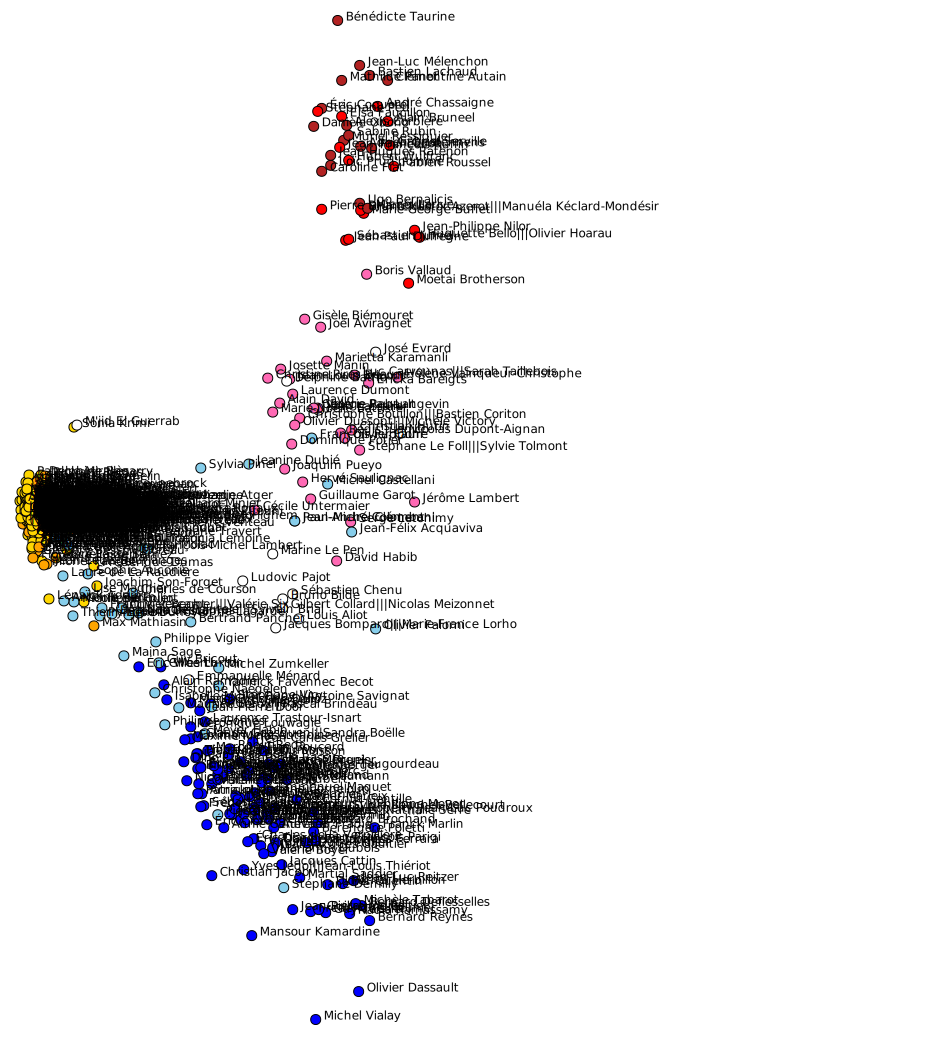

In [25]:
image = svg_graph(position=embedding, names=names, labels=labels, node_size=5, width=400, height=1000, 
                  label_colors=label_colors)
SVG(image)